# A Clean Version of the MPC Implementation

### Imports

In [1]:
from keras.models import Model
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import sys
import os
import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2, denorm_loss, hinge_mse_loss, percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
import helpers
from tqdm import tqdm

Using TensorFlow backend.


573
435
Total: 11061


### Load Files and Model

In [2]:
os.chdir(os.path.expanduser('/home/aiqtidar/test_run/'))
files = [foo for foo in os.listdir() if '.pkl' in foo]
files

['model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_17Nov20-09-22_Scenario-1_params.pkl',
 'model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_17Nov20-09-26_Scenario-1_params.pkl']

In [3]:
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

model = keras.models.load_model('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0.h5', compile=False)
with open('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
        
A,B = get_AB(model)
print("A: " + str(A.shape))
print("B: " + str(B.shape))

W0422 14:50:06.861400 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0422 14:50:06.887326 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0422 14:50:07.128983 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  war

A: (20, 20)
B: (20, 5)


### Prepare Data

In [4]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)

%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}


datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
    
traindata, valdata, normalization_dict = process_data(rawdata,
                                                              scenario['sig_names'],
                                                              scenario['normalization_method'],
                                                              scenario['window_length'],
                                                              scenario['window_overlap'],
                                                              scenario['lookback'],
                                                              scenario['lookahead'],
                                                              scenario['sample_step'],
                                                              scenario['uniform_normalization'],
                                                              1,
                                                              0,
                                                              scenario['nshots'],
                                                              2,
                                                              scenario['flattop_only'],
                                                              pruning_functions=scenario['pruning_functions'],
                                                              invert_q = None, #scenario['invert_q'],
                                                              val_idx = 0,
                                                              excluded_shots=scenario['excluded_shots'],
                                                            randomize=False)
valdata = denormalize(valdata, normalization_dict)
valdata = renormalize(valdata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(valdata,
                                               1,  
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])





Signals: curr, dens, ffprime_EFIT02, gasA, pinj, press_EFIT02, q_EFIT02, temp, tinj
Number of useable shots:  5531
Number of shots used:  5531
Total number of timesteps:  586968
Shots with Complete NaN: 
125691 samples total
Removing weird I-coils
Removed 24703 samples
100988 samples remaining
Removing NaN
Removed 0 samples
100988 samples remaining
Removing dudtrip
Removed 7074 samples
93914 samples remaining
93914 samples remaining after pruning


Normalizing: 100%|##########| 15/15 [00:00<00:00, 167.90it/s]

Total number of samples:  93914
Number of training samples:  84213
Number of validation samples:  9701


### Define Encoders and Decoders

In [5]:
def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    return state_encoder, state_decoder, control_encoder
        
def get_state_and_inputs(scenario,inputs,**kwargs):
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    return x0, control_inputs

def encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs,**kwargs):
    # encode control
    T = scenario['lookback'] + scenario['lookahead']
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
        
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    return x0, u
    
def decode_state(state_decoder,scenario,x,shot,timestep,**kwargs):
    # decode state and organize
    x_decoded = []
    for elem in x:
        x_decoded.append(state_decoder.predict(elem[np.newaxis,:]))
    state_predictions = {}
    residuals = {}
    for i, sig in enumerate(scenario['profile_names']):
        state_predictions[sig] = np.squeeze(np.array([x_decoded[j][i] for j in range(len(x_decoded))]))
        residuals[sig] = state_inputs[sig] - state_predictions[sig]
    return state_inputs, state_predictions, residuals

def get_final_state(state_encoder,scenario,inputs,**kwargs):
    state_inputs = {}
    xf = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,scenario['profile_length']))
        else:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,1))
    
    xf_enc = np.squeeze(state_encoder.predict(xf))
    return xf, xf_enc

model = keras.models.load_model('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0.h5', compile=False)
with open('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')


/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Finalize Data

In [6]:
        
#######################################################################################
state_encoder, state_decoder, control_encoder = get_submodels(model)
x = []
XF = []
enc_x = []
enc_XF = []

inputs = []
enc_inputs = []

for i in range(len(generator)):
    print("Completed {} out of {}".format(i+1,len(generator)),end='\r')
    
    # Get state and input from generators
    temp_x, temp_con_inputs = get_state_and_inputs(scenario,generator[i])
    x.append(temp_x)
    
    
    # Append control inputs
    inputs.append(temp_con_inputs)
    
    # Encode state and inputs
    temp_x, temp_con_inputs = encode_state_and_inputs(state_encoder,control_encoder,scenario,temp_x,temp_con_inputs)
    enc_x.append(temp_x)
    enc_inputs.append(temp_con_inputs)
    
    # Get final encoded state for MPC
    exf, exf_enc = get_final_state(state_encoder,scenario,generator[i])
    XF.append(exf)
    enc_XF.append(exf_enc)

enc_inputs = np.array(enc_inputs)
enc_x = np.array(enc_x)
print("Enc Input: {}".format(enc_inputs.shape))
print("Enc_x: {}".format(enc_x.shape))

Enc Input: (9701, 3, 5)701
Enc_x: (9701, 20)


## Classical MPC Solver

In [7]:
def solve_Classical_MPC_system(Q,R,A,B,x0,n):

    import numpy
    from cvxopt import matrix
    from cvxopt import solvers


    # Define parameters
    N = A.shape[0]
    M = B.shape[1]

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]

    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]

    # Generate R_bar
    R = np.diag(np.ones((M)))
    R_bar = np.kron(np.eye(n),R)

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]

    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on u
    d[rsl,:] = np.ones((M*n,1))*10
    d[slice(M*n,2*M*n),:] = -np.ones((M*n,1))*10

    # Generate F and H matrices
    temp = np.transpose(V).dot(Q_bar)
    F = temp.dot(M_bar)

    temp = np.transpose(V).dot(Q_bar)
    H = temp.dot(V) + R_bar

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)


    P = matrix(H, tc='d')
    q = matrix(F.dot(x0), tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')


    ######################################### Print Solution ###############################
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q)
    # Extract optimal value and solution
    sol['x'] # [7.13e-07, 5.00e+00]
    sol['primal objective'] # 20.0000061731
    
    return sol

### Set Up Q,R

In [8]:
x0 = - enc_x[0] + enc_XF[0]

N = x0.shape[0]
M = enc_inputs.shape[2]

# Generate Q,R
Q = np.eye(N)*1e1
R = np.eye(M)*1e1

n = scenario['lookback'] + scenario['lookahead']
print("Q: {}".format(np.matrix.view(Q)))
print("R: {}".format(np.matrix.view(R)))

Q: [[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0. 

### Solve System

In [9]:
sol_mpc = solve_Classical_MPC_system(Q,R,A,B,x0,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(3, 5)
u_mpc

array([[ 0.01079863, -0.00257567, -0.02112206,  0.00820448, -0.00726315],
       [-0.00820472,  0.00751134,  0.00945584,  0.02711345,  0.01046635],
       [ 0.00637848,  0.00892643, -0.00445302,  0.01154183, -0.00095165]])

## Neo MPC System

In [10]:
def lqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:
    from scipy.linalg import solve_discrete_are
    return solve_discrete_are(A, B, Q, R) 

def solve_Neo_MPC_system(Q,R,A,B,x0,xf,n):
    
    # Imports
    import numpy
    from cvxopt import matrix
    from cvxopt import solvers
    
    # Define parameters
    N = A.shape[0]
    M = B.shape[1]
    print("N: {}".format(N))
    print("M: {}".format(M))
    
    # Reshape to avoid complications
    x0 = x0.reshape((N,1))
    xf = xf.reshape((N,1))

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]
    
#     print("M_bar: {}".format(M_bar))
    
    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n-1):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]
    
    Q_N = lqr(A,B,Q,R)
    rsl = slice((n-1) * N, n * N)
    Q_bar[rsl, rsl] = Q_N
    
#     print("Q_bar: {}".format(Q_bar))

    # Generate R_bar
    R_bar = np.kron(np.eye(n),R)
    
#     print("R_bar: {}".format(R_bar))

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]
    
#     print("V: {}".format(V))
        
    # Generate L
    L = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    L[rsl, :N] = A #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        L[rsl, :N] = L[rsl_p, :N]
        L[rsl, N : (i + 1) * N] = A @ L[rsl_p, : i * N]
    
#     print("L: {}".format(np.matrix.view(L)))
    
    #Generate X_F from x_f
    X_F = np.zeros((N*n,1))
    
    for i in range(0,n):
        rsl = slice(i * N, (i + 1)*N)
        X_F[rsl] = xf
    
#     print("XF: {}".format(X_F))
    
    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on U
    lim = 1
    
    d[rsl,:] = np.ones((M*n,1))*lim
    d[slice(M*n,2*M*n),:] = np.ones((M*n,1))*lim

#     print("D_bar: {}".format(D_bar))
#     print("D: {}".format(d))
    
    # Generate F and H matrices   
    temp = np.transpose(V) @ (Q_bar)
    F = temp @ (M_bar.dot(x0) - X_F) # + L @ (X_F)
    
    temp = np.transpose(V) @ (Q_bar)
    H = temp @ (V) + R_bar
    
#     print("H: {}".format(H))
#     print("F: {}".format(F))

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)

    P = matrix(H, tc='d')
    q = matrix(F, tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')

    ######################################### Print Solution ###############################
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q, G, h)

    return sol

### Set up Q,R

In [61]:
# 0 <= Sample < 9701
sample = 10

x0 = enc_x[sample] 
xf = enc_XF[sample]

N = x0.shape[0]
M = enc_inputs.shape[2]

# Generate Q,R
Q = np.eye(N)*1e5
R = np.eye(M)*1e-3

# Replenish A,B
A,B = get_AB(model)

n = scenario['lookahead']
# print("N: {}".format(N))
# print("M: {}".format(M))
# print("n: {}".format(n))
# print("Q: {}".format(np.matrix.view(Q)))
# print("R: {}".format(np.matrix.view(R)))

### Solve System

In [66]:
scale = 1
sol_mpc = solve_Neo_MPC_system(Q,R,A*scale,B*scale,x0*scale,xf*scale,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(3, 5)
u_mpc

N: 20
M: 5
     pcost       dcost       gap    pres   dres
 0: -2.6016e+04 -2.6056e+04  4e+01  5e-17  4e-16
 1: -2.6016e+04 -2.6017e+04  4e-01  2e-16  3e-16
 2: -2.6016e+04 -2.6016e+04  4e-03  2e-16  3e-16
Optimal solution found.


array([[-0.17309699,  0.00823099,  0.38507943,  0.20081067,  0.3225548 ],
       [-0.19592366,  0.06260469,  0.32180363,  0.16499616,  0.32246535],
       [-0.21234507,  0.0389349 ,  0.3714013 ,  0.17591816,  0.35620721]])

In [63]:
enc_inputs[sample]

array([[-0.03449225, -0.12885451,  0.2934187 ,  0.01138497,  0.089945  ],
       [-0.03730637, -0.12998986,  0.2894535 ,  0.00792312,  0.09240888],
       [-0.03674644, -0.1298328 ,  0.29020435,  0.00855158,  0.09175733]],
      dtype=float32)

In [64]:
# Compare stats
tempx = x0
tempx_mpc = tempx

for i in range (0,n):
    tempx = tempx @ A.T  + enc_inputs[sample][i] @ B.T
    tempx_mpc = tempx_mpc @ A.T  + u_mpc[i] @ B.T
    
diff = np.abs(xf - tempx_mpc)
(diff/np.mean(xf))*100

array([-181.85687927, -151.41299732, -178.81804392,  -10.69148374,
       -301.54452247,   -6.86955517,  -72.43385589, -123.55578949,
       -227.81830843,  -56.70933786, -206.15580757, -124.46038899,
       -134.91734564, -107.77835797,  -47.78534293,  -71.78380467,
       -105.85518105, -159.4155013 , -189.79389515,  -41.0478538 ])

In [44]:
states = []
abs_diff = []
abs_fin_diff = []
abs_aut_diff = []
x_prev = x0
x_prev2 = x0

for i in range(0,n):
    x_new = (A @ x_prev) + np.transpose(B.dot(u_mpc[i]))
    x_new2 = (A @ x_prev2) + np.transpose(B.dot(enc_inputs[sample][i]))    
    
    print("x[{}]: {} \n".format(i+1,x_new))

    states.append(x_prev)
    abs_diff.append(np.linalg.norm(x_new - x_prev))
    abs_fin_diff.append(np.linalg.norm(x_new - xf))
    abs_aut_diff.append(np.linalg.norm(x_new2 - xf))
    x_prev = x_new
    x_prev2 = x_new2

print("Target: {} \n".format(xf))
    

x[1]: [ 0.02846005  0.1098612  -0.05850781 -0.18960925 -0.0525812   0.02890984
 -0.28620279 -0.25645556 -0.01915842 -0.07525047  0.03255272 -0.06590232
  0.18274689  0.13839112  0.07884335  0.08534995  0.19254356  0.06936991
 -0.16804363  0.12074265] 

x[2]: [ 0.00649923  0.09137499 -0.06180383 -0.17840225 -0.01341685  0.03371267
 -0.28071301 -0.25023604 -0.01838    -0.09014121  0.05161976 -0.09134863
  0.15929492  0.13402772  0.07866751  0.10988269  0.18697239  0.09375531
 -0.15364677  0.10163053] 

x[3]: [ 0.0057099   0.08257542 -0.05707767 -0.16637051 -0.01083513  0.03194581
 -0.26756752 -0.2431122  -0.00788684 -0.08389618  0.05138252 -0.08531319
  0.1509474   0.11962163  0.08501104  0.10177482  0.17585247  0.09106364
 -0.13353322  0.09360394] 

Target: [ 0.15350245  0.12214575 -0.11332715 -0.41466784 -0.33550894  0.10794443
 -0.1663664  -0.2786951   0.0263513   0.19868486 -0.32539642  0.19749707
  0.38004357  0.20547949  0.18613936 -0.16940236  0.36004257 -0.35373914
 -0.30555004  

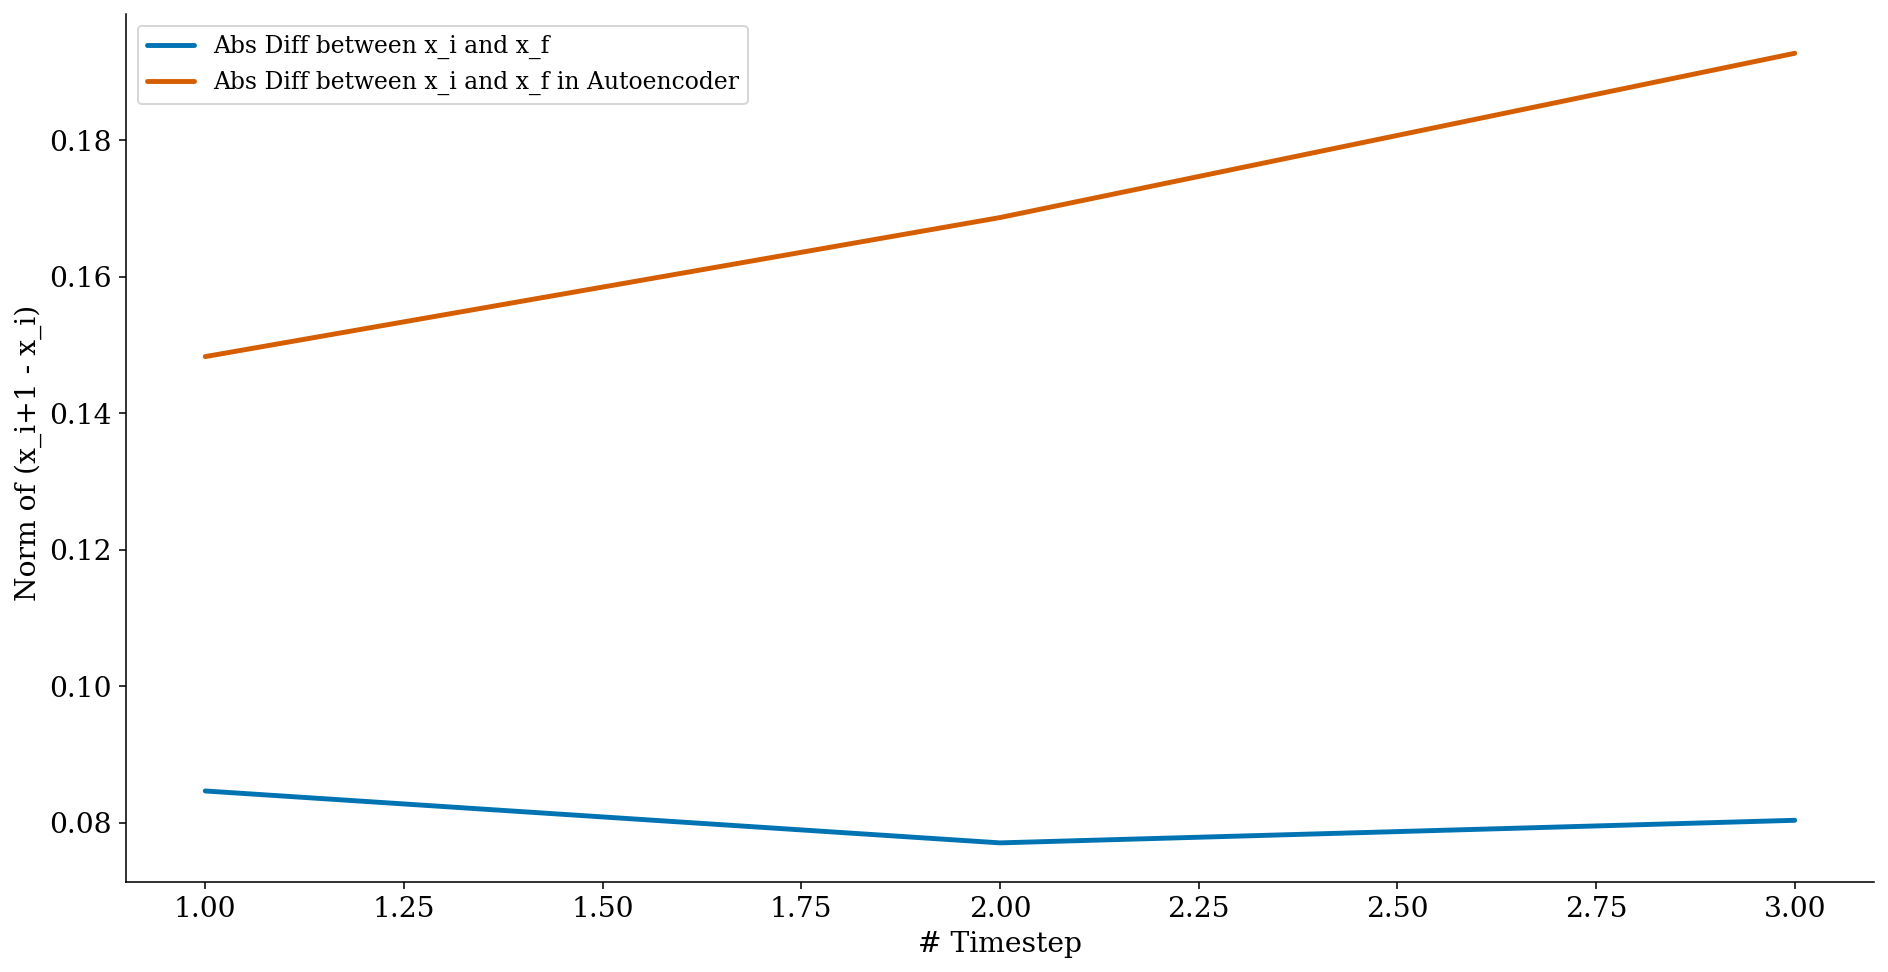

In [16]:
plt.clf()
plt.plot(np.arange(1,n+1),abs_fin_diff)
plt.plot(np.arange(1,n+1),abs_aut_diff)
plt.legend(["Abs Diff between x_i and x_f", "Abs Diff between x_i and x_f in Autoencoder"])
plt.ylabel("Norm of (x_i+1 - x_i) ")
plt.xlabel("# Timestep")
plt.show()

# ETC

In [17]:
A = np.array([[1.1,2], [0,0.95]])
B = np.array([[0],[0.0787]])
C = np.array([-1,1])
# D = 0

x_0 =  np.array([[0],[0]])
# Q =  np.array([[1,0],[0,1]])
Q = np.array([[1,-1],[-1,1]])*1000
R = 0.01
x_f = np.array([[0.5],[-0.5]])*3
n = 50

print("A: {}".format(A))
print("B: {}".format(B))

sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x_0,x_f,n)
sol_mpc = np.array(sol_mpc['x'])
sol_mpc

A: [[1.1  2.  ]
 [0.   0.95]]
B: [[0.    ]
 [0.0787]]
N: 2
M: 1
     pcost       dcost       gap    pres   dres
 0: -2.1815e+05 -2.1872e+05  2e+04  1e+01  4e-14
 1: -2.1689e+05 -2.1549e+05  1e+04  9e+00  3e-14
 2: -2.1511e+05 -2.1378e+05  8e+03  4e+00  5e-14
 3: -2.1510e+05 -2.1290e+05  8e+03  4e+00  3e-14
 4: -2.1300e+05 -2.1062e+05  6e+03  2e+00  2e-14
 5: -2.1123e+05 -2.0937e+05  5e+03  1e+00  3e-14
 6: -2.0962e+05 -2.0822e+05  3e+03  7e-01  2e-14
 7: -2.0811e+05 -2.0734e+05  3e+03  4e-01  2e-14
 8: -2.0684e+05 -2.0666e+05  1e+03  1e-01  2e-14
 9: -2.0611e+05 -2.0618e+05  1e+02  4e-03  3e-14
10: -2.0610e+05 -2.0610e+05  3e+00  1e-04  2e-14
11: -2.0610e+05 -2.0610e+05  3e-02  1e-06  2e-14
12: -2.0610e+05 -2.0610e+05  3e-04  1e-08  2e-14
Optimal solution found.


array([[ 1.00000001],
       [ 1.        ],
       [ 1.        ],
       [ 0.78827709],
       [-1.        ],
       [-1.        ],
       [-0.99999999],
       [-0.99999996],
       [-0.99999975],
       [-0.78798985],
       [ 0.34781096],
       [ 0.05102218],
       [-0.04504236],
       [-0.07601857],
       [-0.08600695],
       [-0.08922775],
       [-0.09026631],
       [-0.0906012 ],
       [-0.09070918],
       [-0.090744  ],
       [-0.09075523],
       [-0.09075885],
       [-0.09076002],
       [-0.09076039],
       [-0.09076051],
       [-0.09076055],
       [-0.09076055],
       [-0.09076051],
       [-0.09076037],
       [-0.09075996],
       [-0.09075866],
       [-0.09075464],
       [-0.09074217],
       [-0.09070351],
       [-0.0905836 ],
       [-0.09021175],
       [-0.08905854],
       [-0.0854822 ],
       [-0.07439117],
       [-0.03999548],
       [ 0.06667346],
       [ 0.3966147 ],
       [-0.15983442],
       [-0.99999994],
       [-0.99999999],
       [-1

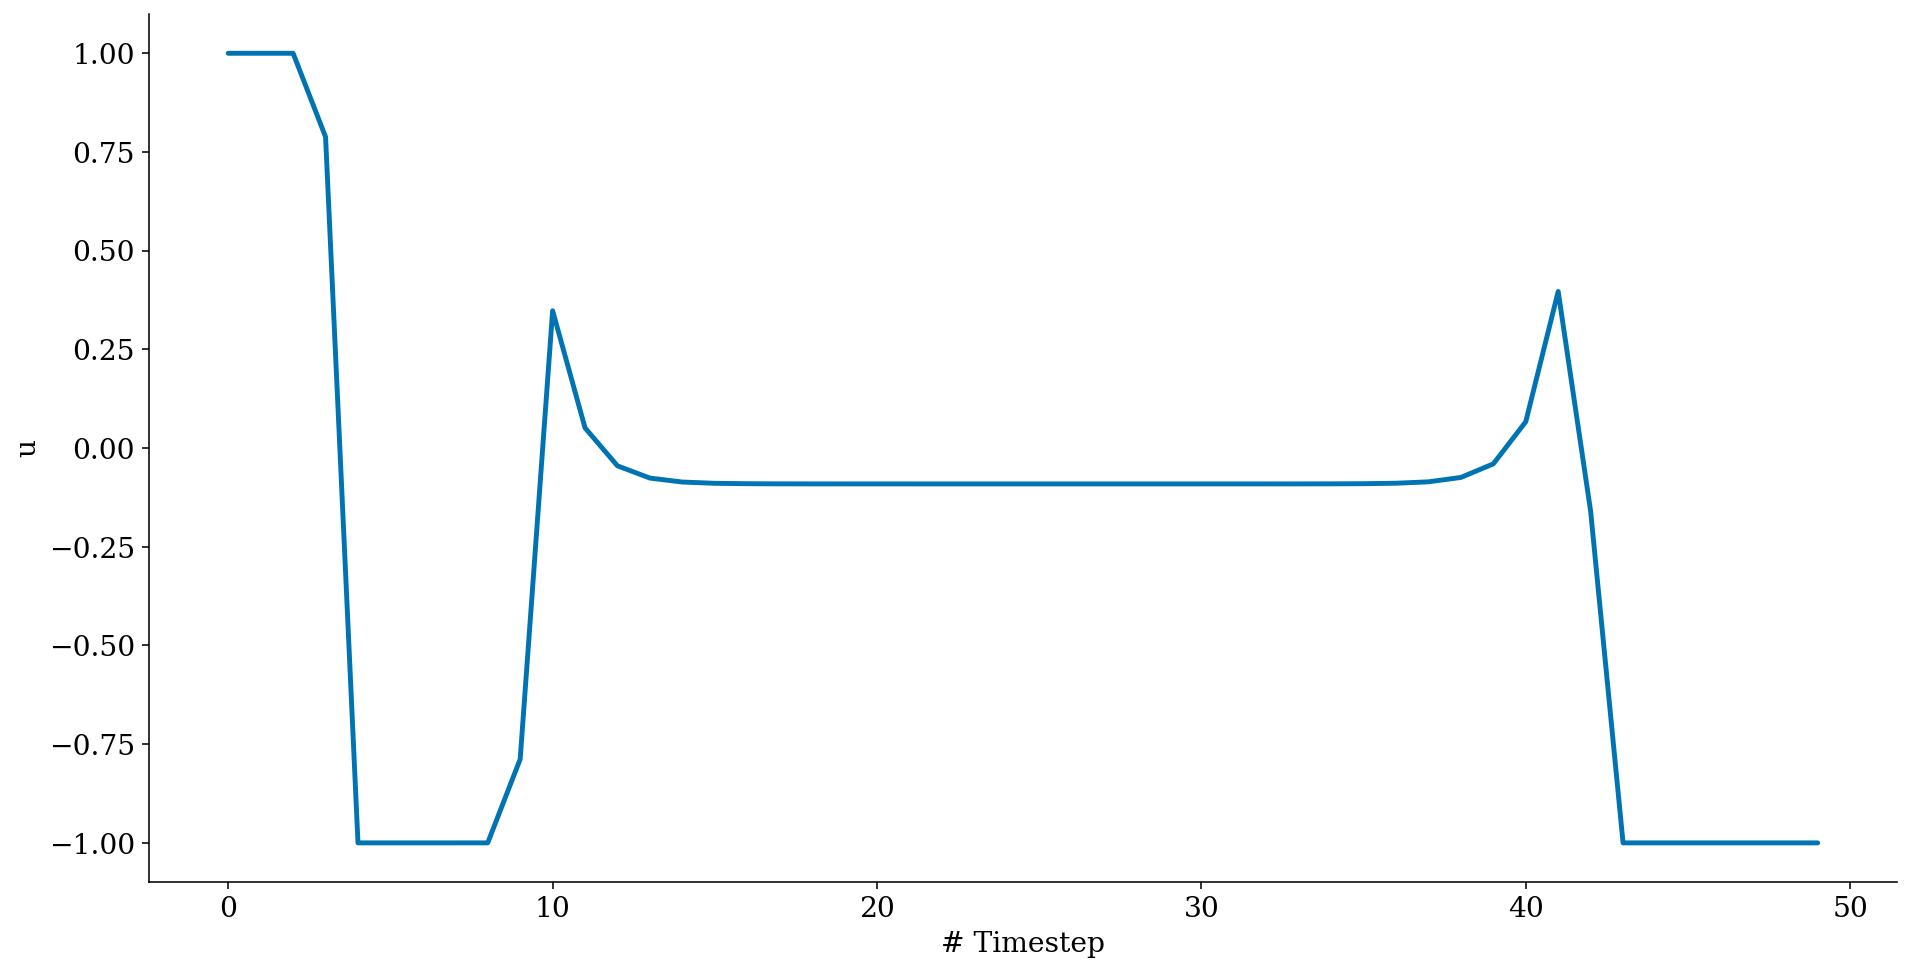

In [18]:
plt.plot(sol_mpc)
# plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("u")
plt.xlabel("# Timestep")
plt.show()

In [19]:
states = []
abs_diff = []
abs_fin_diff = []
x_prev = x_0

lst_sol = np.linalg.lstsq(B, x_f-A @ x_0)
print("lst_sol: {} \n".format(lst_sol))

for i in range(0,n):
    x_new = (A @ x_prev) + np.transpose(B.dot(sol_mpc[i])[np.newaxis])
    print("x[{}]: {} \n".format(i+1,x_new))

    states.append(x_prev)
    abs_diff.append(np.linalg.norm(x_new - x_prev))
    abs_fin_diff.append(np.linalg.norm(x_new - x_f))
    x_prev = x_new

print("Target: {} \n".format(x_f))
    
print(abs_diff[0])
(A @ x_0) + np.transpose(B.dot(lst_sol[0])[np.newaxis])

lst_sol: (array([[-19.05972046]]), array([2.25]), 1, array([0.0787])) 

x[1]: [[0.    ]
 [0.0787]] 

x[2]: [[0.1574  ]
 [0.153465]] 

x[3]: [[0.48007   ]
 [0.22449175]] 

x[4]: [[0.97706051]
 [0.27530457]] 

x[5]: [[1.6253757 ]
 [0.18283934]] 

x[6]: [[2.15359195]
 [0.09499738]] 

x[7]: [[2.5589459 ]
 [0.01154751]] 

x[8]: [[ 2.8379355 ]
 [-0.06772987]] 

x[9]: [[ 2.98626932]
 [-0.14304335]] 

x[10]: [[ 2.99880955]
 [-0.19790599]] 

x[11]: [[ 2.90287853]
 [-0.16063796]] 

x[12]: [[ 2.87189045]
 [-0.14859062]] 

x[13]: [[ 2.86189826]
 [-0.14470592]] 

x[14]: [[ 2.85867624]
 [-0.14345329]] 

x[15]: [[ 2.85763728]
 [-0.14304937]] 

x[16]: [[ 2.85730227]
 [-0.14291913]] 

x[17]: [[ 2.85719424]
 [-0.14287713]] 

x[18]: [[ 2.85715941]
 [-0.14286359]] 

x[19]: [[ 2.85714818]
 [-0.14285922]] 

x[20]: [[ 2.85714455]
 [-0.14285781]] 

x[21]: [[ 2.85714339]
 [-0.14285736]] 

x[22]: [[ 2.85714301]
 [-0.14285721]] 

x[23]: [[ 2.85714289]
 [-0.14285716]] 

x[24]: [[ 2.85714285]
 [-0.14285715]] 

x[2

/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([[[ 0. ],
        [-1.5]]])

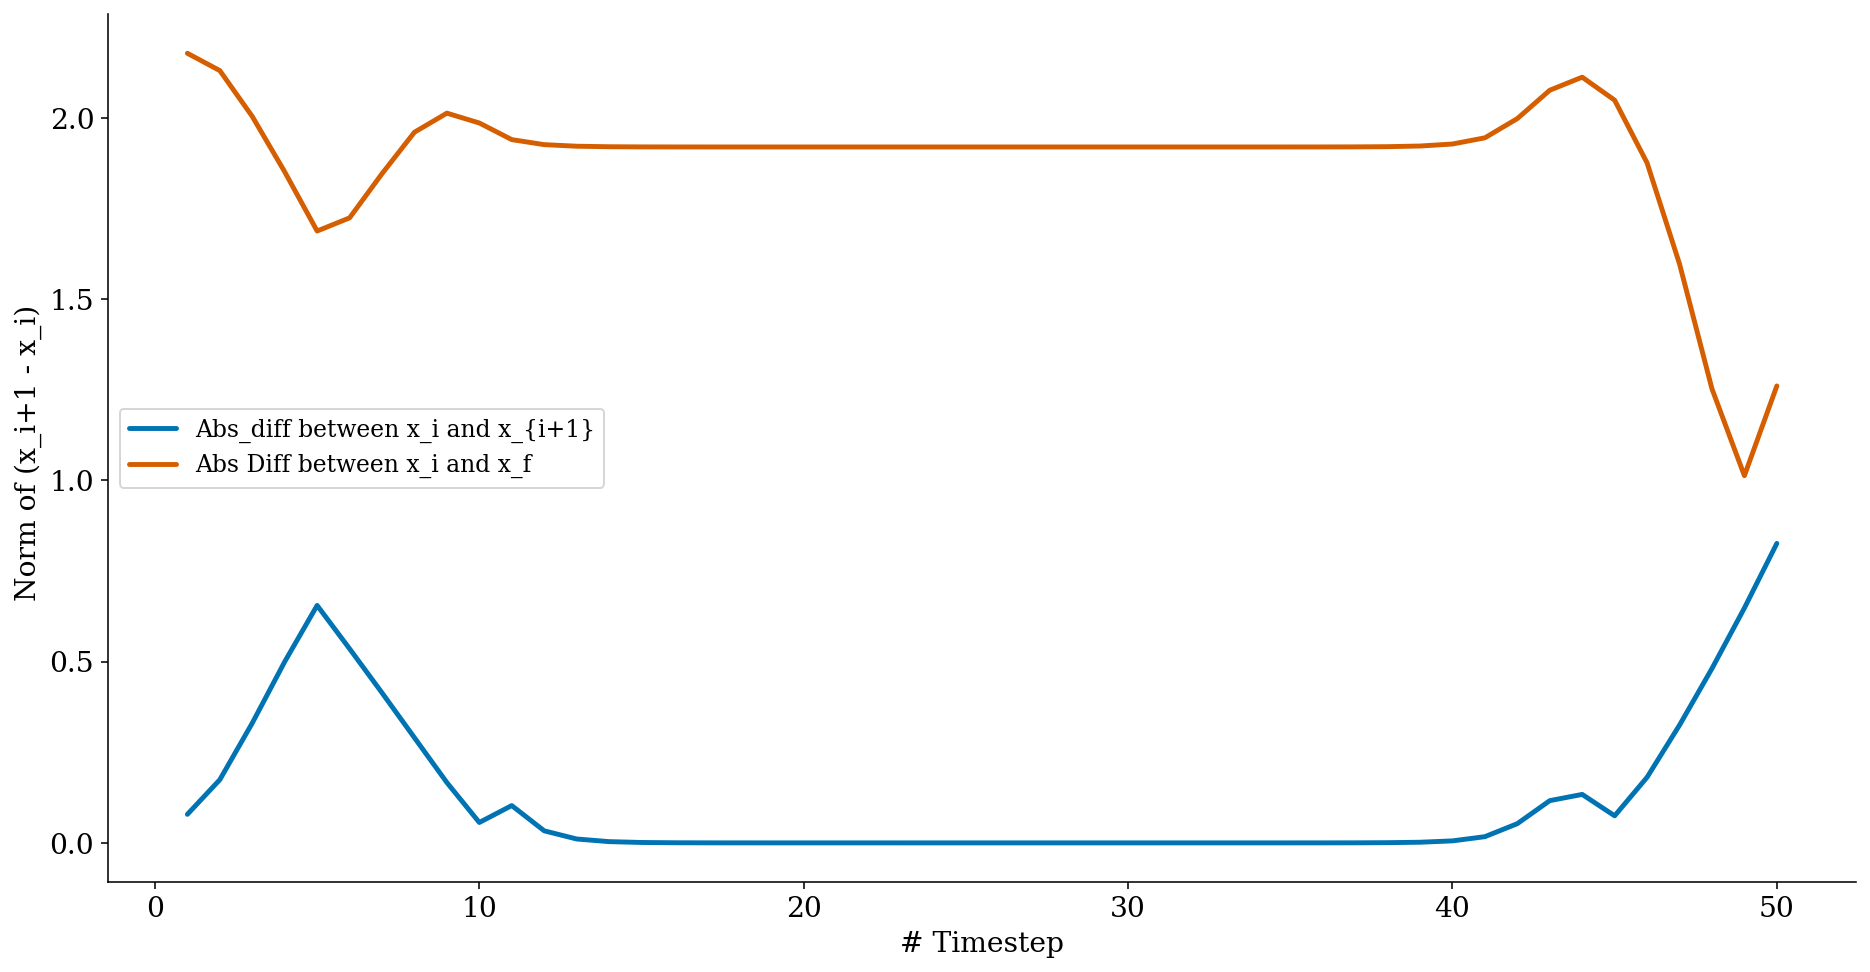

In [20]:
plt.clf()
plt.plot(np.arange(1,n+1),abs_diff)
plt.plot(np.arange(1,n+1),abs_fin_diff)
plt.legend(["Abs_diff between x_i and x_{i+1}", "Abs Diff between x_i and x_f"])
plt.ylabel("Norm of (x_i+1 - x_i) ")
plt.xlabel("# Timestep")
plt.show()


In [21]:
sol_mpc[i]

array([-1.])

In [22]:
sol_mpc.shape

(50, 1)